## Parameter setting and import libraries

In [1]:
from __future__ import print_function
#
import os
import glob
import re
import argparse
import pandas as pd
import numpy as np
import subprocess
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

import time
from time import sleep
from tqdm import tqdm # if use notebook
#from tqdm import tqdm_notebook as tqdm

from threading import Thread, Event, Timer
import queue

from PIL import Image
import cv2
import imgaug as ia
from imgaug import augmenters as iaa

import random

parser = argparse.ArgumentParser()
parser.add_argument('--gpu_id', default="4,5,6,7", type = str)
parser.add_argument('--image_dir', default="/data/seanyu/cat_dog/dataset/") # Path to where you put your data
parser.add_argument('--save_dir', default='/data/seanyu/cat_dog/model/')
parser.add_argument('--batch_size', default=48, type=int)
parser.add_argument('--do_augment', default=True, type = bool)
parser.add_argument('--epochs', default=50, type=int)
parser.add_argument('--lr', default=0.001, type=float)
parser.add_argument('--image_size', default=(200,200,3), type = int)
parser.add_argument('--n_classes', default=2, type = int)
parser.add_argument('--n_batch', default=100, type = int)
parser.add_argument('--train_ratio', default=0.99, type = float)
parser.add_argument('--use_model_ckpt', default = None, type = str)
parser.add_argument('--model_file_name', default = 'tmp_nb')
parser.add_argument('--n_threads', default = 4, type = int)
parser.add_argument('--dq_size', default = 6, type = int)
parser.add_argument('--use_pretrain', default = True, type = bool)
FLAGS = parser.parse_args([])
print(FLAGS)

/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  retu

Namespace(batch_size=48, do_augment=True, dq_size=6, epochs=50, gpu_id='4,5,6,7', image_dir='/data/seanyu/cat_dog/dataset/', image_size=(200, 200, 3), lr=0.001, model_file_name='tmp_nb', n_batch=100, n_classes=2, n_threads=4, save_dir='/data/seanyu/cat_dog/model/', train_ratio=0.99, use_model_ckpt=None, use_pretrain=True)


/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Check path and load data

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(FLAGS.gpu_id)
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
import keras.backend as K
n_gpu = len(FLAGS.gpu_id.split(","))
""" 
horovod for keras setting
"""
if n_gpu > 1:
    print("Numbers of GPUs: %i" % n_gpu)
    import horovod.keras as hvd
    hvd.init()
    #config = tf.ConfigProto()
    #config.gpu_options.visible_device_list = str(hvd.local_rank())
    #K.set_session(tf.Session(config=config))


if not os.path.exists(FLAGS.save_dir):
    os.makedirs(FLAGS.save_dir)

model_dir = FLAGS.save_dir + '/model'
    
graphs_dir = FLAGS.save_dir + '/graphs'
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)

"""  Get data """
d_train = FLAGS.image_dir + '/train/'
d_test = FLAGS.image_dir + '/test1/'

image_train_list = glob.glob(d_train + '*.jpg')
image_test_list = glob.glob(d_test + '*.jpg')

df_train = pd.DataFrame({'img_path': image_train_list})
df_test = pd.DataFrame({'img_path': image_test_list})

df_train['cate'] = df_train.img_path.apply(os.path.basename)
df_train['cate'] = [i.split(".")[0] for i in list(df_train.cate)]
df_train.cate = df_train.cate.replace({'dog': 0, 'cat': 1})

nb_epoch = FLAGS.epochs

df_train_0, df_val_0 = train_test_split(df_train[df_train['cate'] == 0].sample(n=5000), test_size = 1-FLAGS.train_ratio)
df_train_1, df_val_1 = train_test_split(df_train[df_train['cate'] == 1].sample(n=5000), test_size = 1-FLAGS.train_ratio)

df_val = pd.concat((df_val_0, df_val_1)).reset_index(drop = True)

del df_val_0, df_val_1

/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Numbers of GPUs: 4


In [3]:
def cv_load_and_resize(x, image_size, is_training = True, do_augment = False, seq = None):
    im_w, im_h, im_c = image_size
    im = cv2.imread(x)
    im = cv2.resize(im, (im_w, im_h))
    if do_augment and is_training:
        im = seq.augment_image(im)
    return im

# Read them all
x_train = np.array([cv_load_and_resize(i, image_size=FLAGS.image_size) for i in pd.concat((df_train_0, df_train_1)).img_path])
y_train = pd.concat((df_train_0, df_train_1)).cate.values
y_train = to_categorical(y_train)


x_val = np.array([cv_load_and_resize(i, image_size=FLAGS.image_size, is_training = False) for i in df_val.img_path])
y_val = df_val.cate.values
y_val = to_categorical(y_val)

print("Training set size: ", x_train.shape)
print("Validation set size: ", x_val.shape)

Training set size:  (9898, 200, 200, 3)
Validation set size:  (102, 200, 200, 3)


## Callbacks

In [4]:
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

model_ckpt = ModelCheckpoint(filepath=FLAGS.save_dir + 'model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, monitor='val_loss', patience=4, verbose=1)
earlystop = EarlyStopping(min_delta=1e-8, monitor='val_loss', patience=10, verbose=1)
tbCallBack = TensorBoard(log_dir=FLAGS.save_dir+'/graphs', histogram_freq=0, write_graph=True, write_images=True)

## Build model

In [5]:
import keras.backend as K
from keras.layers import (
    Conv2D, 
    Input, 
    Dense, 
    GlobalAveragePooling2D, 
    Activation
)
from keras.models import (
    Model, 
    load_model, 
    save_model)
from keras.optimizers import (
    SGD, 
    Adam, 
    TFOptimizer)
from keras.callbacks import (
    Callback, 
    ReduceLROnPlateau, 
    ModelCheckpoint, 
    EarlyStopping)

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.utils.generic_utils import get_custom_objects

#K.clear_session()

if FLAGS.use_pretrain:
    epoch_to_run = 25
    res_model = ResNet50(include_top=False, input_shape=FLAGS.image_size, weights=None)
    
    x = GlobalAveragePooling2D()(res_model.output)
    out = Dense(units=2, activation="softmax")(x)
    
    model = Model(inputs=[res_model.input], 
                  outputs=[out])
else:
    epoch_to_run = 50

optim = Adam(lr = FLAGS.lr)

if n_gpu > 1:
    optim = hvd.DistributedOptimizer(optim)
    callbacks = [hvd.callbacks.BroadcastGlobalVariablesCallback(0),
                ]
    if hvd.rank() == 0:
        callbacks.append(model_ckpt)
        callbacks.append(tbCallBack)
else:
    callbacks = [model_ckpt, reduce_lr, earlystop, tbCallBack]

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=optim)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [6]:
history_model = model.fit(x_train, y_train, 
          batch_size=FLAGS.batch_size, 
          epochs=epoch_to_run, 
          shuffle=True, verbose=1, 
          validation_data=(x_val, y_val),
          callbacks = callbacks)

Train on 9898 samples, validate on 102 samples
Epoch 1/25
9898/9898 [==============================] - 79s 8ms/step - loss: 0.8599 - acc: 0.6016 - val_loss: 0.6317 - val_acc: 0.6176

Epoch 00001: val_loss improved from inf to 0.63165, saving model to /data/seanyu/cat_dog/model/model.h5
Epoch 2/25
9898/9898 [==============================] - 71s 7ms/step - loss: 0.6324 - acc: 0.6688 - val_loss: 0.8593 - val_acc: 0.5392

Epoch 00002: val_loss did not improve
Epoch 3/25
9898/9898 [==============================] - 72s 7ms/step - loss: 0.6035 - acc: 0.6955 - val_loss: 0.7783 - val_acc: 0.5490

Epoch 00003: val_loss did not improve
Epoch 4/25
9898/9898 [==============================] - 72s 7ms/step - loss: 0.5496 - acc: 0.7200 - val_loss: 0.6035 - val_acc: 0.6961

Epoch 00004: val_loss improved from 0.63165 to 0.60351, saving model to /data/seanyu/cat_dog/model/model.h5
Epoch 5/25
9898/9898 [==============================] - 71s 7ms/step - loss: 0.4932 - acc: 0.7636 - val_loss: 0.8752 - va

### Visualization with Grad-CAM

In [2]:
from keras.models import load_model
import keras.backend as K
model = load_model("/data/seanyu/cat_dog/model/model.h5")

/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
layer = 'add_16' # layer before GAP and last activation
idx = 201
sess = K.get_session()


In [4]:
#sess.graph.get_tensor_by_name(layer)
#model.layers
op = sess.graph.get_operations()
#tmp = [m.values() for m in op]
tmp = [m.values() for m in op if layer in m.name]
#tmp = [tmp[i][0].name for i in np.arange(len(tmp))]
tmp

[(<tf.Tensor 'add_16/add:0' shape=(?, 8, 8, 2048) dtype=float32>,),
 (<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Shape:0' shape=(4,) dtype=int32>,),
 (<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Shape_1:0' shape=(4,) dtype=int32>,),
 (<tf.Tensor 'training/Adam/gradients/add_16/add_grad/BroadcastGradientArgs:0' shape=(?,) dtype=int32>,
  <tf.Tensor 'training/Adam/gradients/add_16/add_grad/BroadcastGradientArgs:1' shape=(?,) dtype=int32>),
 (<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Sum:0' shape=<unknown> dtype=float32>,),
 (<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Reshape:0' shape=(?, 8, 8, 2048) dtype=float32>,),
 (<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Sum_1:0' shape=<unknown> dtype=float32>,),
 (<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Reshape_1:0' shape=(?, 8, 8, 2048) dtype=float32>,),
 (<tf.Tensor 'training/Adam/add_16:0' shape=(64,) dtype=float32>,),
 (<tf.Tensor 'training/Adam/add_160:0' shape=(512,) dtype=float32>,),

In [65]:
#tmp.remove('')
[print(i) for i in tmp if i != '']

(<tf.Tensor 'add_16/add:0' shape=(?, 8, 8, 2048) dtype=float32>,)
(<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Shape:0' shape=(4,) dtype=int32>,)
(<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Shape_1:0' shape=(4,) dtype=int32>,)
(<tf.Tensor 'training/Adam/gradients/add_16/add_grad/BroadcastGradientArgs:0' shape=(?,) dtype=int32>, <tf.Tensor 'training/Adam/gradients/add_16/add_grad/BroadcastGradientArgs:1' shape=(?,) dtype=int32>)
(<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Sum:0' shape=<unknown> dtype=float32>,)
(<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Reshape:0' shape=(?, 8, 8, 2048) dtype=float32>,)
(<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Sum_1:0' shape=<unknown> dtype=float32>,)
(<tf.Tensor 'training/Adam/gradients/add_16/add_grad/Reshape_1:0' shape=(?, 8, 8, 2048) dtype=float32>,)
(<tf.Tensor 'training/Adam/add_16:0' shape=(64,) dtype=float32>,)
(<tf.Tensor 'training/Adam/add_160:0' shape=(512,) dtype=float32>,)
(<tf.Tensor 'training

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [8]:
def grad_cam(model, image, cls_select, tf_sess, layer, alpha = 0.6):
    # Visualization with Grad-CAM
    if image.shape != 4:
        # Should be batch input, because we're going to send it into model
        image = np.expand_dims(image, axis = 0)
    H,W = image.shape[1], image.shape[2]

    #tf_sess = K.get_session()
    y_c = model.output[0, cls_select] # output tensor -> take slice of selected class
    conv_output = model.get_layer(layer).output # layer tensor
    grads = tf.gradients(y_c, conv_output)[0]

    output, grads_val = tf_sess.run([conv_output, grads], 
                                    feed_dict = {model.input.name:image})
    # --> shape: output = grads_val = 1 x 8 x 8 x 2048
    output, grads_val = output[0, :], grads_val[0, :,:,:]
    # --> shape: output = 8 x 8 x 2048,  grads_val = 8 x 8 x 2048

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.dot(output, weights) 
    # --> shape: cam = 8 x 8

    ## resize it ##
    cam = tf.image.resize_bicubic(images=cam[np.newaxis, : , :, np.newaxis], 
                             size=(H, W))
    cam = cam[0, :, :, 0]
    cam = tf.maximum(cam, 0)
    cam = cam / tf.reduce_max(cam)
    cam = tf_sess.run(cam)
    ## do image merge ##
    # smooth the image (because upsampling make image grid-like)
    
    # apply color map
    mapping = cv2.applyColorMap(np.uint8(255 * (1-cam) ), cv2.COLORMAP_JET)
    mapping = cv2.GaussianBlur(mapping, (11,11), 5)
    mapping = np.concatenate((mapping, ((mapping.max(axis=-1) - 128 )*255*alpha)[:,:,np.newaxis]), axis = -1)

    # foreground - background
    background = Image.fromarray(image[0])
    foreground = Image.fromarray(mapping.astype('uint8'))
    background.paste(foreground, (0, 0), foreground)
    
    return cam, background

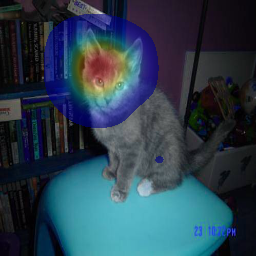

In [11]:
layer = 'add_16' # layer before GAP and last activation
idx = 201
sess = K.get_session()
cam_out, cam_map = grad_cam(model = model, tf_sess=sess,
                            image = x_val[idx], cls_select= y_val[idx].argmax(), layer=layer)
cam_map